In [254]:
# for domonkos to run on COLAB

import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/python/Computer_Vision/TDT4265_Project/')

Mounted at /content/drive


In [255]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
from src.data import load_train_test_val, load_tee
from src.visualize import plot_loss_acc
from src.model import Unet2D
from src.train import train
from src.utils import save_result
from src.test import test
from src.metrics import acc_metric
from datetime import datetime

from params import *


import torch
from torch import nn

## Prepare data

In [257]:
train_data, test_data, valid_data = load_train_test_val(DATA_PARAMS, PREP_STEPS, TRAIN_TRANSFORMS)

tee_data = load_tee(DATA_PARAMS['base_path'], DATA_PARAMS['batch_size'])


Items loaded: 1800 [training: 1440, test: 180, valid: 180]
RAW IMAGES: torch.Size([8, 1, 384, 384])
 GT IMAGES: torch.Size([8, 384, 384])

TEE IMAGES: 19
RAW TEE IMAGES: torch.Size([8, 1, 384, 384])
 GT IMAGES: torch.Size([8, 384, 384])



## Train

In [258]:
# MODEL: Unet2D (one input channel, 4 output channels)
# Outputs: Probabilities for each class for each pixel in different layer)
unet = Unet2D(1, out_channels=4)
print(unet)

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=LEARN_RATE)

Unet2D(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Dropout2d(p=0.1, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Dropout2d(p=0.1, inplace=False)
    (7): 

Epoch 1/1
----------
Current step: 40  Loss: 0.9754012227058411  Acc: 0.7534578442573547 Val Loss: 0.9999553561210632 Val Acc: 0.787884533405304 
Current step: 80  Loss: 0.9031090140342712  Acc: 0.8453462719917297 Val Loss: 0.9474548697471619 Val Acc: 0.8354430794715881 
Current step: 120  Loss: 0.8983047008514404  Acc: 0.8317015171051025 Val Loss: 0.9345207214355469 Val Acc: 0.8447262644767761 
Current step: 160  Loss: 0.8983740210533142  Acc: 0.8462295532226562 Val Loss: 0.9338958859443665 Val Acc: 0.8457397818565369 
Epoch 1/1
----------
Train Loss: 0.9477 Acc: 0.7966964244842529
----------
Elapsed time is 0:01:26.303595


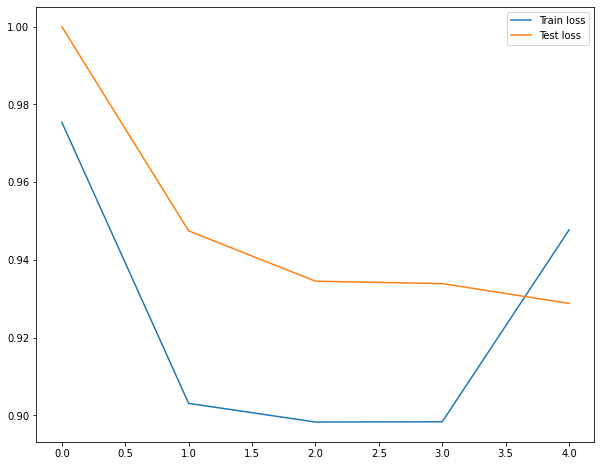

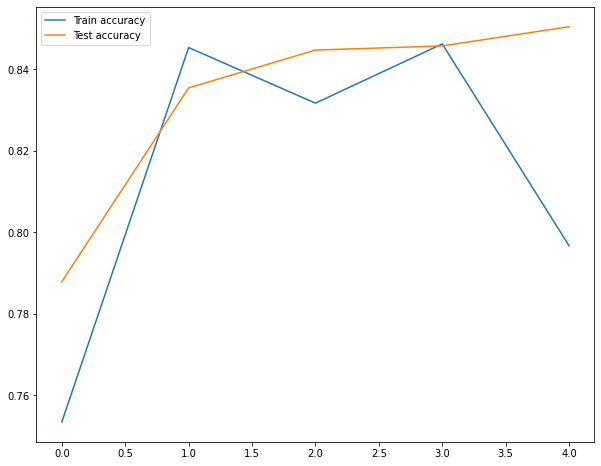

In [259]:
LOAD = False
if LOAD:
    unet.load_state_dict(torch.load(MODEL_PATH+FILE_NAME))
    print(f"Model '{FILE_NAME}' loaded")
else:
  start = datetime.now()

  # Training process
  train_loss, test_loss, train_acc, test_acc = train(unet, train_data, test_data, loss_fn, opt, acc_metric, epochs=EPOCHS)

  end = datetime.now()

  print("Elapsed time is {}".format(str(end-start)))

  plot_loss_acc(train_loss, test_loss, train_acc, test_acc)

## Test

TEST on the CAMUS dataset


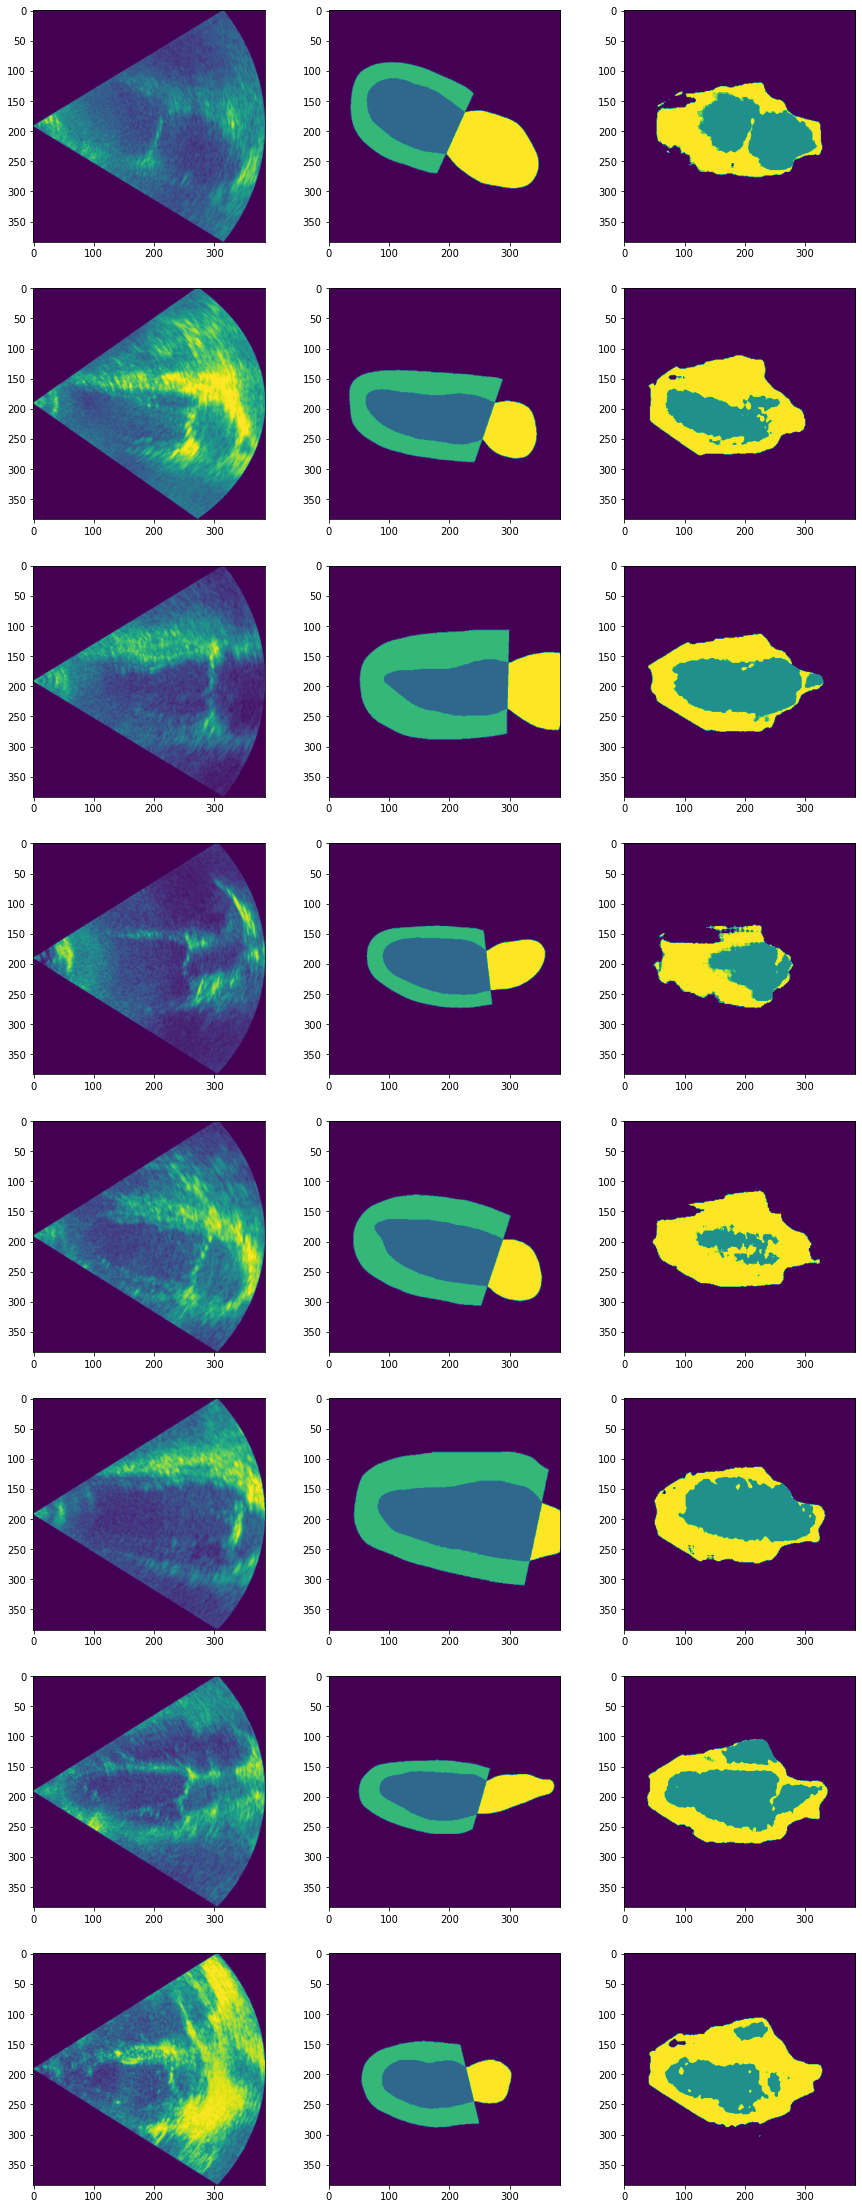


Final Accuracy: 0.841 (delta to baseline -0.1296)
Final average DICE score: 0.6794 [0.7191, 0.6025, 0.3973, 0.9985] (delta to baseline 0.0719)


In [260]:
print("TEST on the CAMUS dataset")
accuracy, average_dice, class_dice = test(unet, valid_data, True)

Test on TEE images


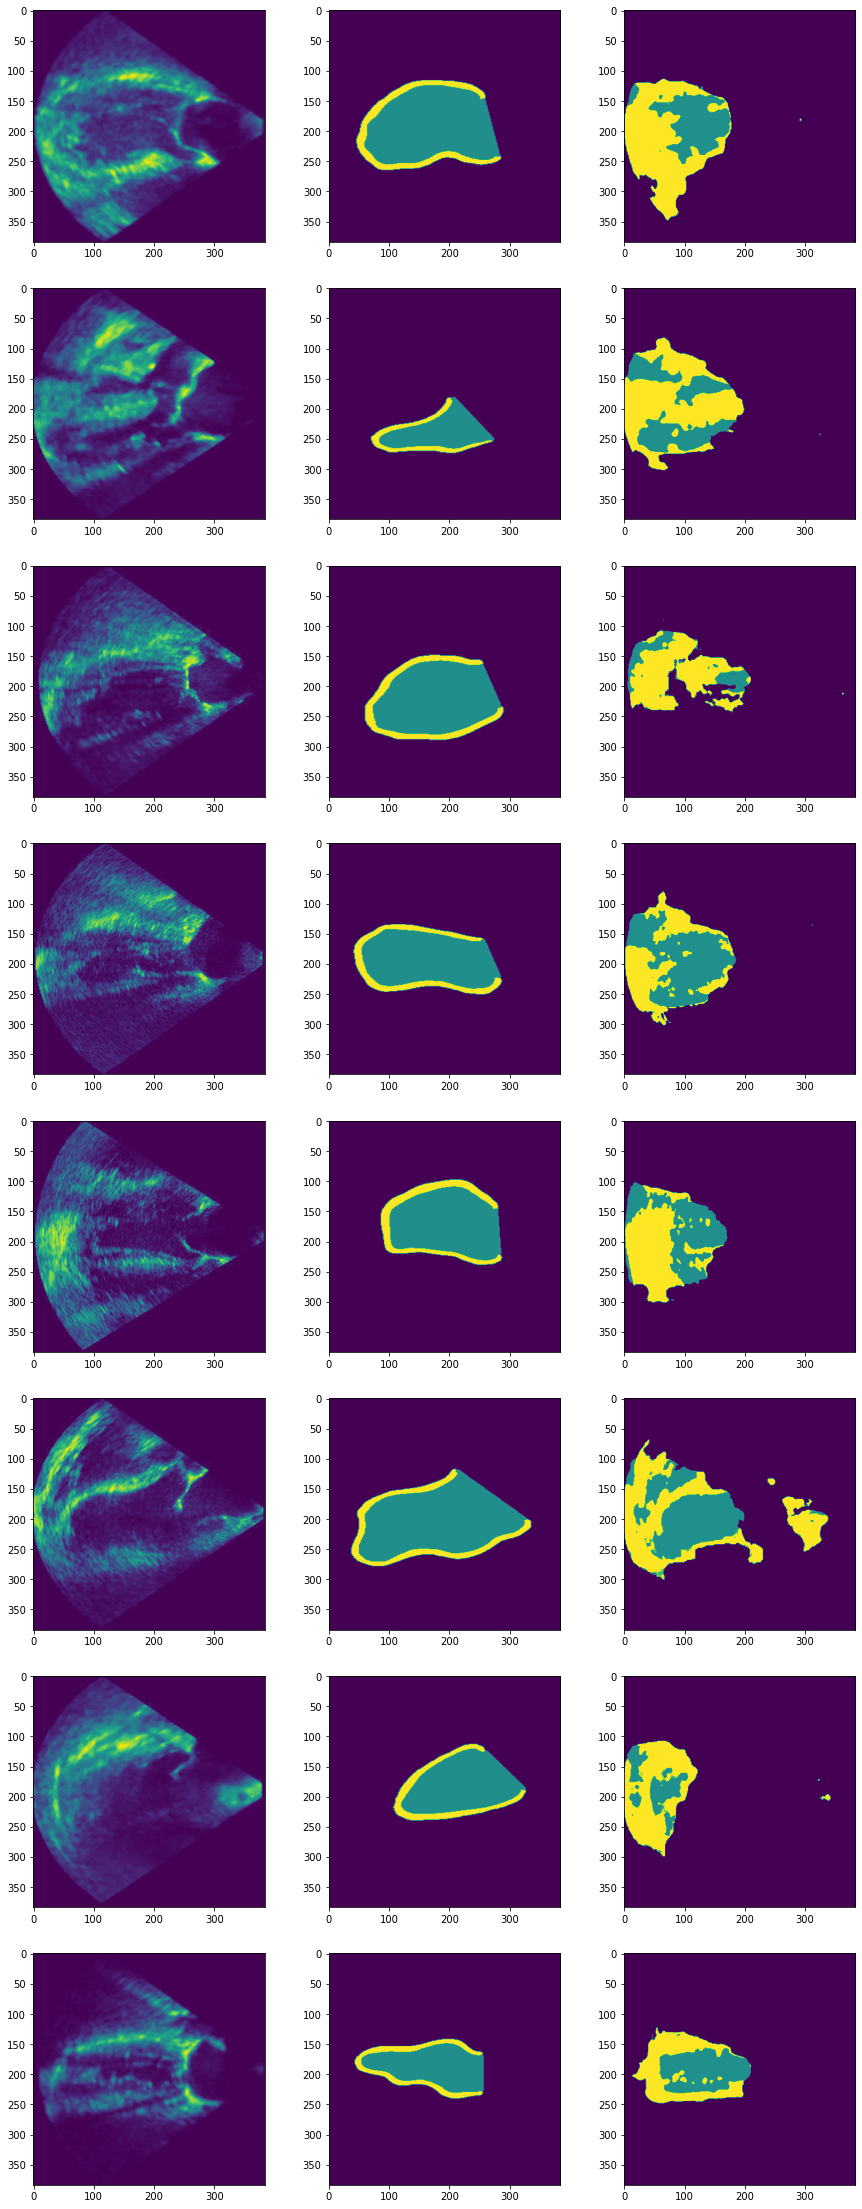


Final Accuracy: 0.7582 (delta to baseline -0.2124)
Final average DICE score: 0.5129 [-0.153, 0.5342, 0.6714, 0.999] (delta to baseline -0.0945)


In [262]:
print("Test on TEE images")
accuracy, average_dice, class_dice = test(unet, tee_data, True)

In [ ]:
# save the result
msg = 'Test the saving function'

file_name = 'baseline'

# Save the model
save_result(unet, file_name, accuracy, average_dice, class_dice, msg = msg )